## Goals:
- make a histogram of the lepton pt as a regular variable,  the "cut" as a string category, the Z boson pt as another regular variable and finally the deltaR(Z boson, lepton) as another regular variable
- save each of the selection cuts currently applied now as different masks
- for each mask save the candidate lepton pT distribution in the histogram, save the cut in the string category, and save the Z boson pt, and the deltaR(z boson, candidate lepton)
- for the Z boson pT you can do something similar to our gen matching i.e. find the Z boson gen particle in the event

In [1]:
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea import nanoevents
from coffea import processor
import time

import argparse
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
import pickle as pkl
import pandas as pd
import os
import sys
sys.path.append("../")

from collections import defaultdict
import pickle as pkl
import pyarrow as pa
import awkward as ak
import numpy as np
import pandas as pd
import json
import os
import shutil
import pathlib
from typing import List, Optional
import pyarrow.parquet as pq

from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection
from boostedhiggs.utils import match_HWW
from boostedhiggs.btag import btagWPs
from boostedhiggs.btag import BTagCorrector

import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from hist.intervals import clopper_pearson_interval

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# import uproot
# f = uproot.open(f"../datafiles/DYJetsToLL_Pt-50To100.root")
# num = f['Events'].num_entries   ### checks number of events per file 
# print(f'number of events per file is {num}')

# events = nanoevents.NanoEventsFactory.from_root(f, "Events").events()

In [3]:
# define the configuration and processor
job_name = '/0-1'
channels=['ele', 'mu', 'had']
pt_bins = ["DYJetsToLL_Pt-50To100","DYJetsToLL_Pt-100To250", "DYJetsToLL_Pt-250To400", "DYJetsToLL_Pt-400To650", "DYJetsToLL_Pt-650ToInf" ]

for pt_bin in pt_bins:
    fileset = {}
    print(f"Processing pt_bin: {pt_bin}")
    fileset[pt_bin] = [f"../datafiles/{pt_bin}.root"]

    outfiles = "./" + pt_bin + "/"

    # remove output directory to store fresh samples
    if os.path.exists(outfiles):
        shutil.rmtree(outfiles)

    from boostedhiggs.hwwprocessor_nocuts import HwwProcessor_nocuts
    p = HwwProcessor_nocuts(year='2017', channels=channels, output_location=outfiles + job_name)
    
    executor = processor.IterativeExecutor(status=True)
    run = processor.Runner(
        executor=executor, savemetrics=True, schema=nanoevents.NanoAODSchema, chunksize=10000
    )

    out, metrics = run(
    fileset, "Events", processor_instance=p
    )

    # dump to pickle
    filehandler = open(outfiles + job_name + '.pkl', "wb")
    pkl.dump(out, filehandler)
    filehandler.close()

    # merge parquet
    for ch in channels:
        data = pd.read_parquet(outfiles + job_name + ch + '/parquet')
        data.to_parquet(outfiles + job_name + '_' + ch + '.parquet')

        # remove old parquet files
        os.system('rm -rf ' + outfiles + job_name + ch)

        data_jets = pd.read_parquet(outfiles + job_name + '/jets/' + ch + '/parquet')
        data_jets.to_parquet(outfiles + job_name + '_jets_' + ch + '.parquet')

    # remove old parquet files
    os.system('rm -rf ' + outfiles + job_name)        

Processing pt_bin: DYJetsToLL_Pt-50To100


Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/10 [00:00<?, ?chunk/s]

Processing pt_bin: DYJetsToLL_Pt-100To250


Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/6 [00:00<?, ?chunk/s]

/opt/anaconda3/envs/coffea-env/lib/python3.7/site-packages/awkward/_connect/_numpy.py:210: RuntimeWarning: divide by zero encountered in log
  *[nplike.asarray(x) for x in inputs], **kwargs


Processing pt_bin: DYJetsToLL_Pt-250To400


Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/3 [00:00<?, ?chunk/s]

Processing pt_bin: DYJetsToLL_Pt-400To650


Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/1 [00:00<?, ?chunk/s]

Processing pt_bin: DYJetsToLL_Pt-650ToInf


Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/3 [00:00<?, ?chunk/s]

In [4]:
job_name = '/0-1'
channels=['ele', 'mu', 'had']
pt_bins = ["DYJetsToLL_Pt-50To100","DYJetsToLL_Pt-100To250", "DYJetsToLL_Pt-250To400", "DYJetsToLL_Pt-400To650", "DYJetsToLL_Pt-650ToInf" ]

data = {}
data_jets = {}
metadata = {}

for pt_bin in pt_bins:
    data[pt_bin] = {}
    data_jets[pt_bin] = {}
    
    outfiles = "./" + pt_bin + "/"
    
    for ch in channels:  
        data[pt_bin][ch] = pq.read_table(outfiles + job_name + '_' + ch + '.parquet').to_pandas()
        data_jets[pt_bin][ch] = pq.read_table(outfiles + job_name + '_jets_' + ch + '.parquet').to_pandas()

    with open(outfiles + job_name + '.pkl', 'rb') as f:
        metadata[pt_bin] = pkl.load(f)

# No cuts applied yet

### 1D-histograms with single axis

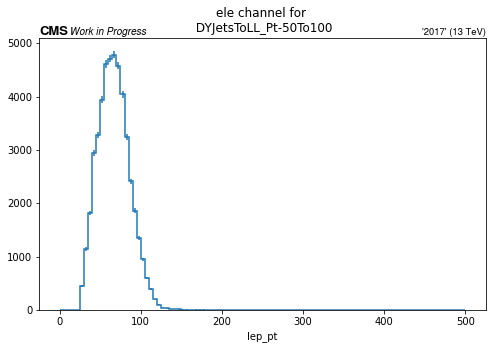

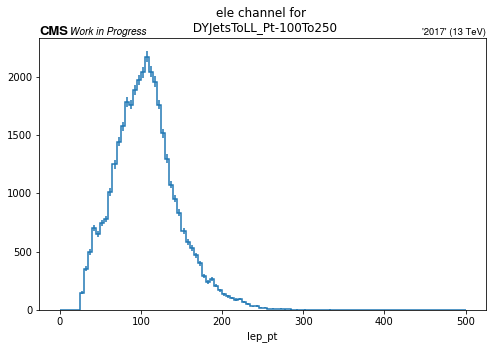

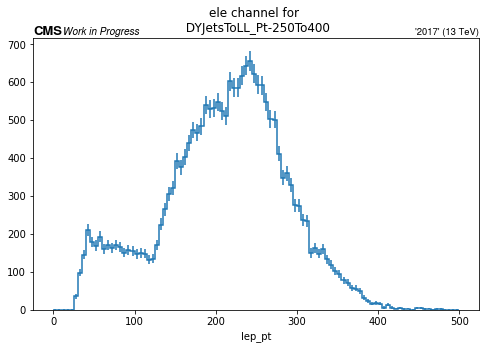

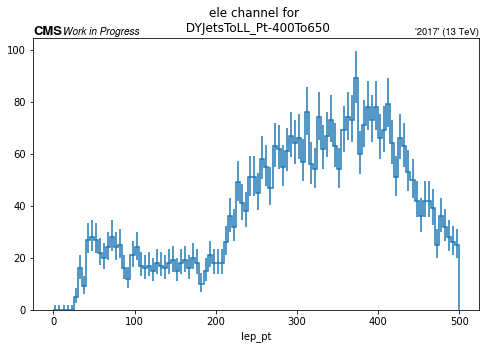

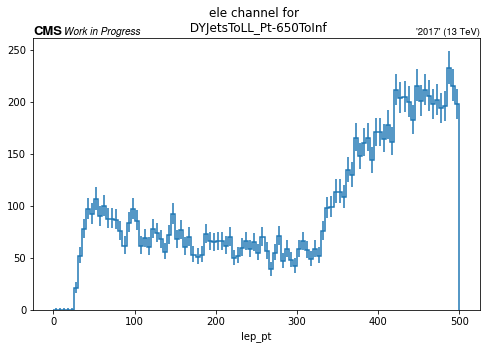

In [5]:
for pt_bin in pt_bins:
    h = hist2.Hist(
        hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),
    )
    h.fill(data[pt_bin]['ele']['lep_pt']
          )

    odir = pt_bin + '/jets'
    fig, ax = plt.subplots(figsize=(8, 5))
    hep.histplot(h, ax=ax)
    # ax.set_xlabel(f"{'btag_max'}")
    ax.set_title(f'ele channel for \n {pt_bin}')
    hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)

    if not os.path.exists(f'{odir}/'):
        os.makedirs(f'{odir}/')

    plt.savefig(f'{odir}/lep_pt_wth_btag_threshold.pdf')
## 1D-histograms with single axis:    plt.close()

## 1D-histograms stacked

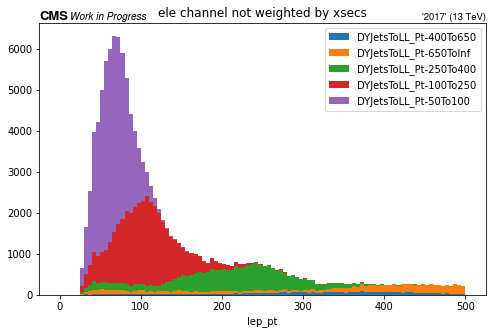

In [72]:
# stacked
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),
    hist2.axis.StrCategory([], name='PT bin', label=pt_bin, growth=True),
)
for pt_bin in pt_bins:
    h.fill(data[pt_bin]['ele']['lep_pt'], pt_bin
          )

odir = './all/'

fig, ax = plt.subplots(figsize=(8, 5))
hep.histplot([h[{"PT bin": pt_bin}] for pt_bin in pt_bins], stack=True, sort='yield', histtype="fill", ax=ax, label=[pt_bin for pt_bin in pt_bins])
ax.set_title(f'ele channel not weighted by xsecs')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)
ax.legend()

if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/lep_pt_stacked_noxsecs.pdf')
plt.show()
plt.close();

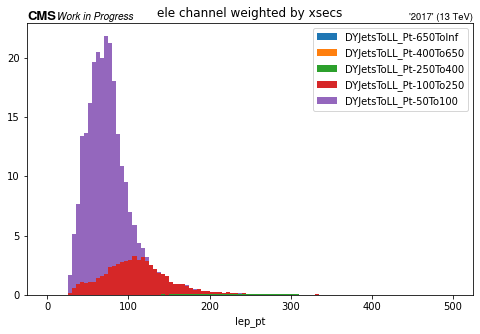

In [76]:
# scale by xsecs
import glob
def get_sum_sumgenweight(pt_bin):
    pkl_files = glob.glob(f'{pt_bin}/*.pkl')  # get the pkl metadata of the pkl files that were processed
    sum_sumgenweight = 0
    for file in pkl_files:
        # load and sum the sumgenweight of each
        with open(file, 'rb') as f:
            metadata = pkl.load(f)
        sum_sumgenweight = sum_sumgenweight + metadata[pt_bin]['2017']['sumgenweight']
    return sum_sumgenweight

def get_xsec_weight(pt_bin):
    f = open('../fileset/xsec_pfnano.json')
    xsec = json.load(f)
    f.close()
    return (eval(str((xsec[pt_bin]))) / (get_sum_sumgenweight(pt_bin)))


# recall the PT bins
pt_bins = ["DYJetsToLL_Pt-50To100", "DYJetsToLL_Pt-100To250", "DYJetsToLL_Pt-250To400", "DYJetsToLL_Pt-400To650", "DYJetsToLL_Pt-650ToInf" ]


# stacked scaled by xsecs
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),
    hist2.axis.StrCategory([], name='PT bin', label=pt_bin, growth=True),
)
for pt_bin in pt_bins:
    event_weight = data[pt_bin]['ele']['weight']
    h.fill(data[pt_bin]['ele']['lep_pt'], pt_bin, weight= event_weight * get_xsec_weight(pt_bin)
          )

odir = './all/'

fig, ax = plt.subplots(figsize=(8, 5))
hep.histplot([h[{"PT bin": pt_bin}] for pt_bin in pt_bins], stack=True, sort='yield', histtype="fill", ax=ax, label=[pt_bin for pt_bin in pt_bins])
ax.set_title(f'ele channel weighted by xsecs')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)
ax.legend()

# ax.set_yscale('log')
# ax.set_ylim(0.1)

if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/lep_pt_stacked_xsecs.pdf')
plt.show()
plt.close();

# Apply cuts

In [153]:
# make a cut dict to map the "cut label" to the actual cut
cut_dict = {}
for pt_bin in pt_bins:
    cut_dict[pt_bin] = {'lep_pt':            (data[pt_bin]['ele']['leptonKin']>40),
                        'oneElectron':       (data[pt_bin]['ele']['oneElectron']),
                        'notaus_ele':        (data[pt_bin]['ele']['notaus_ele']),''
                        'ElectronIsolation': (data[pt_bin]['ele']['ElectronIsolation']==1),
                        'mt_lep_met':        (data[pt_bin]['ele']['mt_lep_met']==1),
                        'anti_bjettag':      (data[pt_bin]['ele']['anti_bjettag']==1),
                        'leptonInJet':       (data[pt_bin]['ele']['leptonInJet']==1)
                       }

def apply_cuts(pt_bin, cuts = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'anti_bjettag', 'leptonInJet']):

    '''
    takes as input a list of cut names (any of the "cutdict" keys defined above)
    returns output as a boolean array to apply on the events
    '''
    for i, cut in enumerate(cuts):
        if i==0:
            combined_bool = cut_dict[pt_bin][cut]
        else:
            combined_bool = pd.concat([combined_bool,cut_dict[pt_bin][cut]], axis=1)
    
    if len(cuts)==1:
        return combined_bool
    return combined_bool.all(axis=1)

In [165]:
# recall the PT bins
pt_bins = ["DYJetsToLL_Pt-50To100", "DYJetsToLL_Pt-100To250", "DYJetsToLL_Pt-250To400", "DYJetsToLL_Pt-400To650", "DYJetsToLL_Pt-650ToInf" ]

normal_cuts = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met']
normal_plus_btag = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'anti_bjettag']
normal_plus_dR = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'leptonInJet']
normal_plus_btag_plus_dR = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'anti_bjettag', 'leptonInJet']

def plot(cut_choice, label, xsecs):
    
    '''
    takes as input
    (1) a cut_choice from the ones define above
    (2) a label for the title of the hist
    (3) boolean for xsecs to specefy whether to weight PT bins by xsecs 
    '''
    
    h = hist2.Hist(
        hist2.axis.Regular(50,0, 250, name='lepton_pt', label='lepton_pt', flow=True),
        hist2.axis.StrCategory([], name='PT bin', growth=True)
    )

    for pt_bin in pt_bins:
        if xsecs:
            event_weight = data[pt_bin]['ele']['weight'].clip(lower=0)[apply_cuts(pt_bin, cut_choice)]
            
            h.fill(
                data[pt_bin]['ele']['lep_pt'][apply_cuts(pt_bin, cut_choice)], pt_bin, weight= event_weight * get_xsec_weight(pt_bin)
            )
        else:
            h.fill(
                data[pt_bin]['ele']['lep_pt'][apply_cuts(pt_bin, cut_choice)], pt_bin,
            )

    odir = './all'

    fig, ax = plt.subplots(figsize=(8, 5))
    hep.histplot([h[{"PT bin": pt_bin}] for pt_bin in pt_bins], stack=True, sort='yield', histtype="fill", ax=ax, label=[pt_bin for pt_bin in pt_bins])
    ax.set_xlabel(f"{'lep_pt'}")
    
    if xsecs:
        ax.set_title(f'ele channel after applying {label} \n weighted by xsecs')
    else:    
        ax.set_title(f'ele channel after applying {label} \n not weighted by xsecs')
    
    hep.cms.lumitext(f"2017 (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    ax.legend()

    ax.set_yscale('log')
#     ax.set_ylim(0.1)
    if not os.path.exists(f'{odir}/'):
        os.makedirs(f'{odir}/')

    plt.savefig(f'{odir}/{cut_choice}_noxsecs.pdf')
    #     plt.close()    


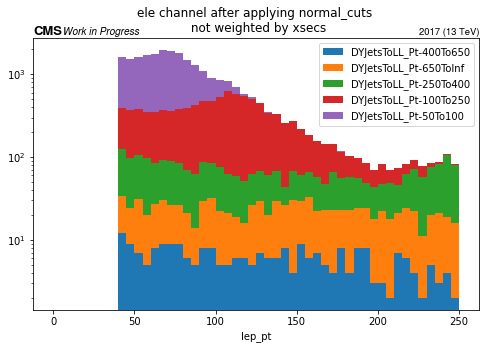

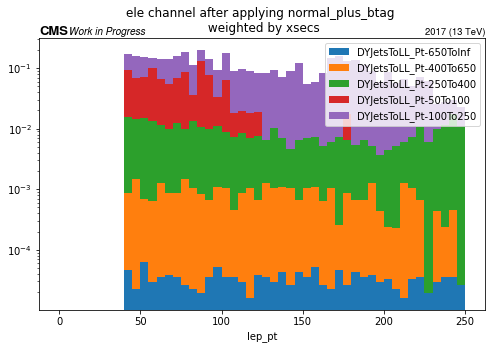

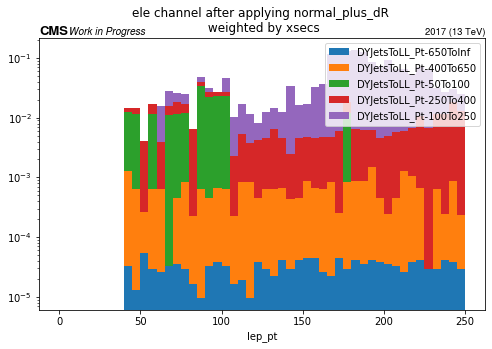

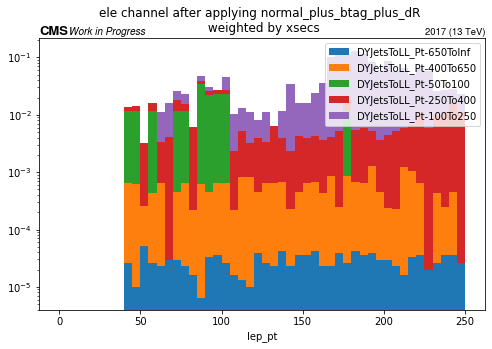

In [166]:
plot(normal_cuts, 'normal_cuts', xsecs=False)
plot(normal_plus_btag, 'normal_plus_btag', xsecs=True)
plot(normal_plus_dR, 'normal_plus_dR', xsecs=True)
plot(normal_plus_btag_plus_dR, 'normal_plus_btag_plus_dR', xsecs=True)

## 2D-plot

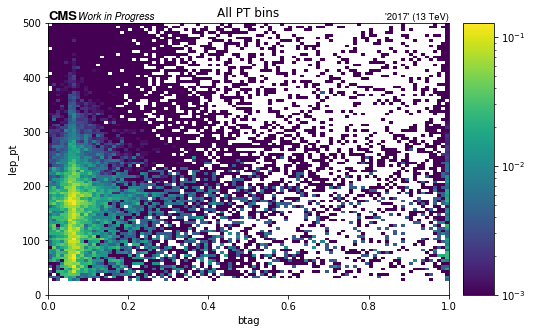

In [167]:
# btag vs lep_pt
h = hist2.Hist(
    hist2.axis.Regular(100,0, 1, name='btag', label='btag', flow=True),
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),
    hist2.axis.StrCategory([], name='PT bin', growth=True),
)

for pt_bin in pt_bins:
    event_weight = data[pt_bin]['ele']['weight'].clip(lower=0)
    h.fill(data[pt_bin]['ele']['jets_outside_btag_max'], data[pt_bin]['ele']['lep_pt'], pt_bin, weight= event_weight * get_xsec_weight(pt_bin)
    )

odir = './all/'

fig, ax = plt.subplots(figsize=(8, 5))
hep.hist2dplot(h[{"PT bin": sum}], ax=ax, norm=matplotlib.colors.LogNorm(vmin=1e-3))    
ax.set_title(f'All PT bins')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)


if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/btag_vs_lep_pt.pdf')